Labeled sequence of bitter peptides.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [68]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [69]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [70]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [71]:
df = train_pos.append(train_neg).append(test_pos).append(test_neg).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
df

,bitter,seq
0,Positive,GFF
1,Positive,VYPFPPGIGG
2,Positive,EVLN
3,Positive,KAVPYPPQ
4,Positive,FV
...,...,...
635,Negative,MIFPGGPQL
636,Negative,HHL
637,Negative,HIR
638,Negative,NILP


In [72]:
df = df.sample(frac=1, random_state=1)
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [73]:
descriptors = list(set([j for i in seq for j in i]))
enc = OneHotEncoder()
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = enc.fit(X)

In [74]:
def create_graph_data(str, label):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

In [75]:
data_list = []

In [76]:
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])

    data_list.append(d)

In [77]:
train_data, test_data = train_test_split(data_list, test_size=0.1, random_state=0)

In [78]:
train_loader = DataLoader(train_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=64)

In [79]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[160, 20], edge_index=[2, 256], y=[32], batch=[160], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[148, 20], edge_index=[2, 232], y=[32], batch=[148], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[149, 20], edge_index=[2, 234], y=[32], batch=[149], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[167, 20], edge_index=[2, 270], y=[32], batch=[167], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[192, 20], edge_index=[2, 320], y=[32], batch=[192], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[195, 20], edge_index=[2, 326], y=[32], batch=[195], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[184, 20], edge_index=[2, 304], y=[32], batch=[184], ptr=[33])

Step 8:
Number of graphs in the current batch: 32
DataBatch(x=[143, 20], edge_index=[2, 222], y=[32], batch=[143], ptr

In [80]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [81]:
hidden_channels = 16
epochs = 30

In [82]:
model = GCN(hidden_channels=hidden_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.7587, Test Acc: 0.7500
Epoch: 001, Train Acc: 0.8038, Test Acc: 0.7500
Epoch: 002, Train Acc: 0.8524, Test Acc: 0.7656
Epoch: 003, Train Acc: 0.8542, Test Acc: 0.7812
Epoch: 004, Train Acc: 0.8611, Test Acc: 0.7500
Epoch: 005, Train Acc: 0.8455, Test Acc: 0.7812
Epoch: 006, Train Acc: 0.8663, Test Acc: 0.7656
Epoch: 007, Train Acc: 0.8681, Test Acc: 0.7812
Epoch: 008, Train Acc: 0.8611, Test Acc: 0.7500
Epoch: 009, Train Acc: 0.8767, Test Acc: 0.7812
Epoch: 010, Train Acc: 0.8576, Test Acc: 0.7812
Epoch: 011, Train Acc: 0.8715, Test Acc: 0.7344
Epoch: 012, Train Acc: 0.8767, Test Acc: 0.7969
Epoch: 013, Train Acc: 0.9028, Test Acc: 0.7812
Epoch: 014, Train Acc: 0.8733, Test Acc: 0.8125
Epoch: 015, Train Acc: 0.8976, Test Acc: 0.7812
Epoch: 016, Train Acc: 0.9097, Test Acc: 0.8125
Epoch: 017, Train Acc: 0.9201, Test Acc: 0.7656
Epoch: 018, Train Acc: 0.8889, Test Acc: 0.7656
Epoch: 019, Train Acc: 0.9236, Test Acc: 0.7656
Epoch: 020, Train Acc: 0.8941, Test Acc:

In [83]:
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

In [84]:
out.shape

torch.Size([64, 2])

In [85]:
lab.shape

torch.Size([64])

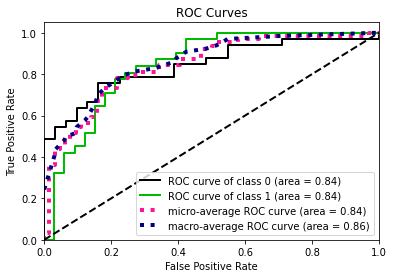

In [86]:
skplt.metrics.plot_roc(lab, out.detach().numpy())
plt.show()

In [87]:
model

GCN(
  (conv1): GCNConv(20, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)

In [88]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [89]:
train_graph_embeddings = []
for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        train_graph_embeddings.append(d)
len(train_graph_embeddings)    

576

In [90]:
test_graph_embeddings = []
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        test_graph_embeddings.append(d)
len(test_graph_embeddings)    

64

In [91]:
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings

## Graph level embedding

### All embeddings

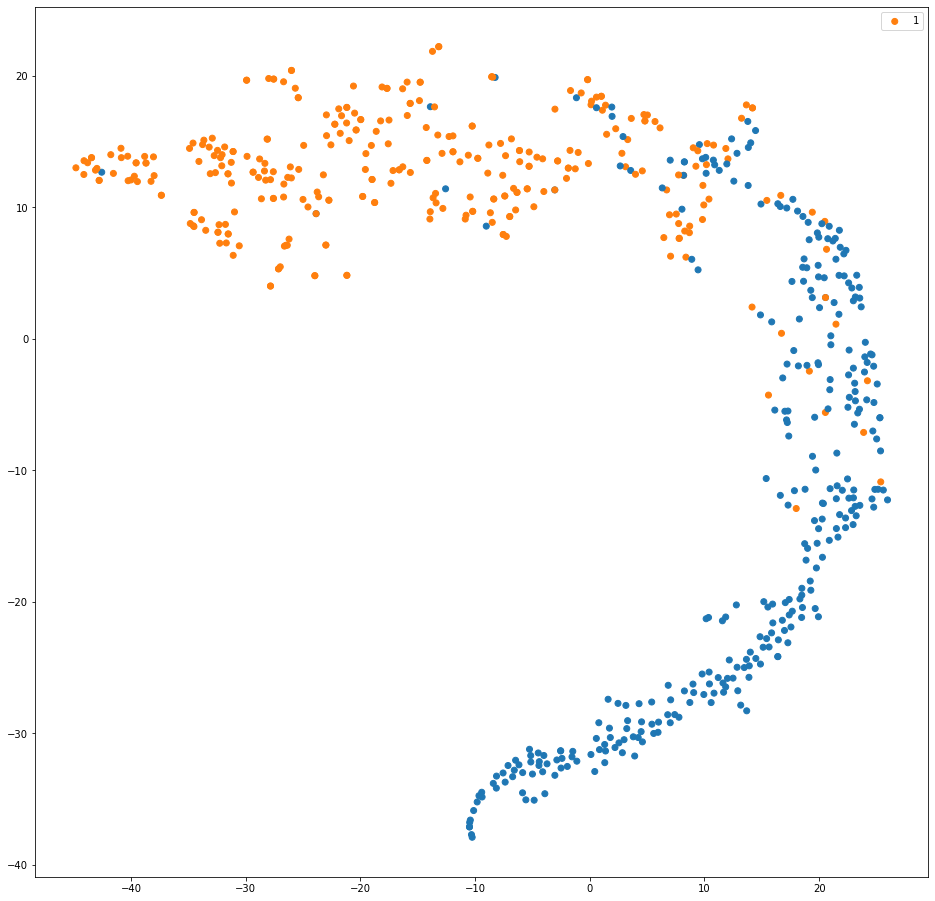

In [92]:
descs = []
conv_feats = np.zeros((len(all_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats[i] = all_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])
tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
plt.show()
#for i, l in enumerate(descs):
#    plt.annotate(l, (pca_embd[i, 0], pca_embd[i, 1]))

### Train

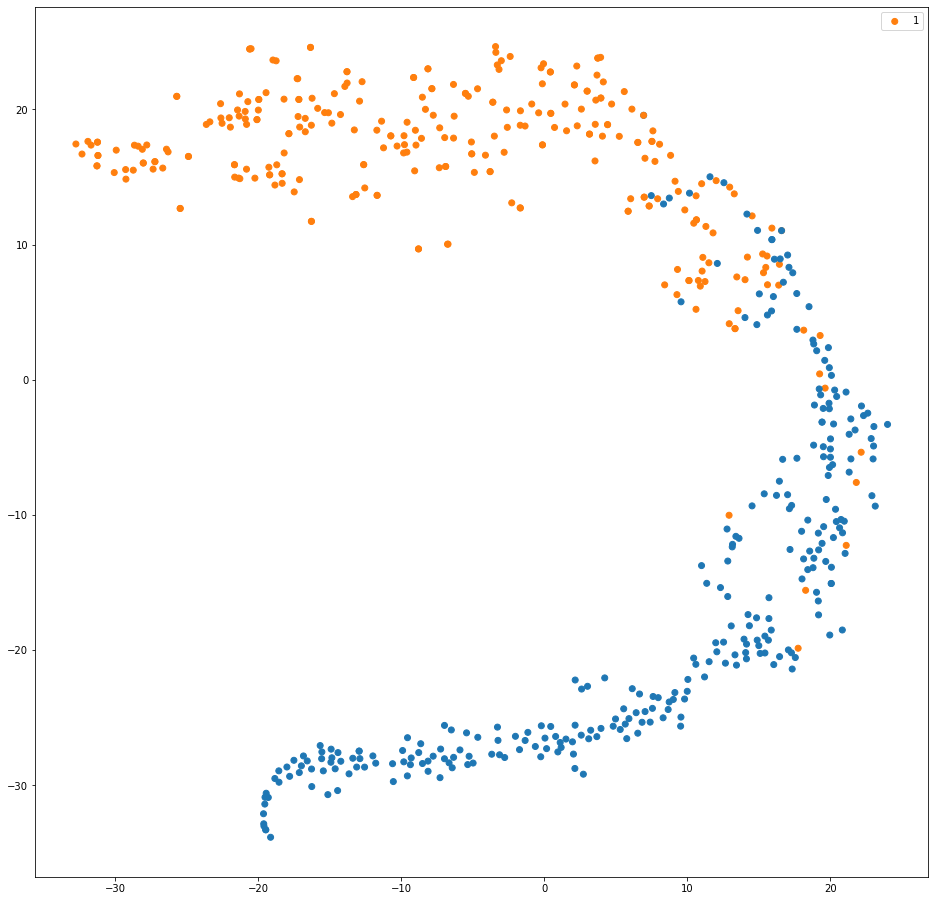

In [93]:
descs = []
conv_feats = np.zeros((len(train_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(train_graph_embeddings)):
    descs.append(train_graph_embeddings[i]['desc'])
    conv_feats[i] = train_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(train_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
plt.show()
#for i, l in enumerate(descs):
#    plt.annotate(l, (pca_embd[i, 0], pca_embd[i, 1]))

#### Test

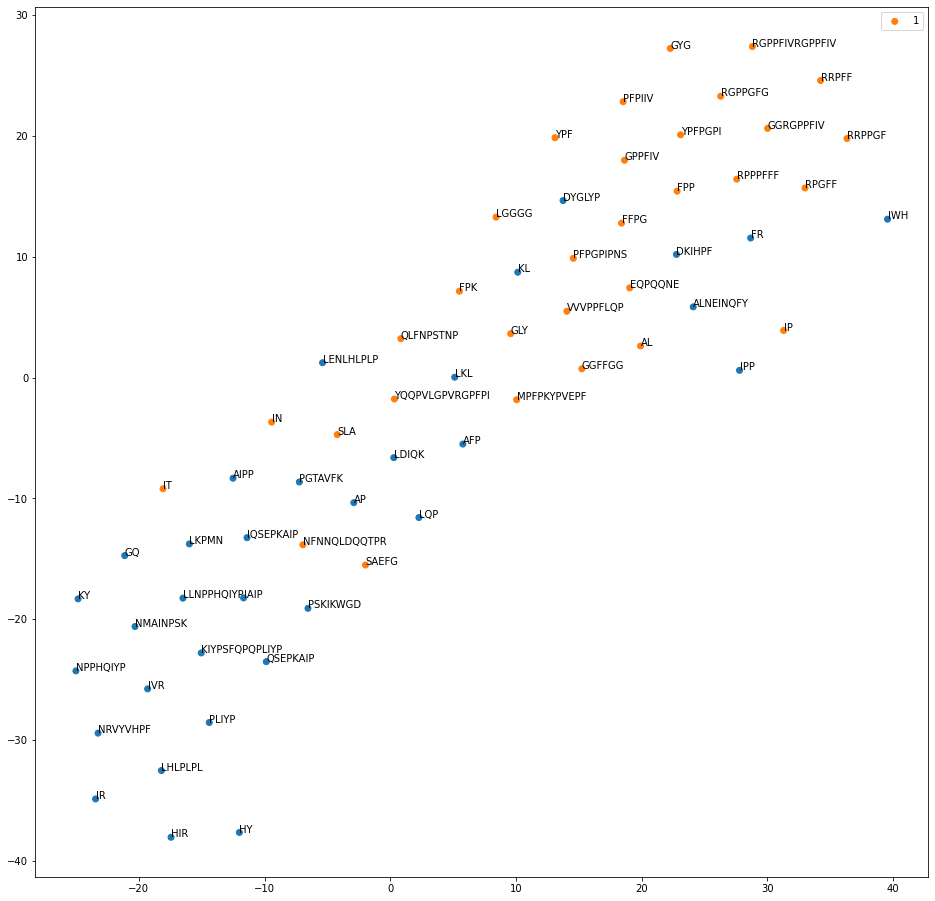

In [94]:
descs = []
conv_feats = np.zeros((len(test_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(test_graph_embeddings)):
    descs.append(test_graph_embeddings[i]['desc'])
    conv_feats[i] = test_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(test_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
for i, l in enumerate(descs):
    plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]))
plt.show()

## Node level embeddings: All Data 

In [95]:
descs = []
conv_feats = []
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats.append(all_graph_embeddings[i]['conv3_feats'].mean(axis = 1).detach().tolist())
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])


In [108]:
pos_samples = []
neg_samples = []
for i in range(len(conv_feats)):
    if labels[i] == 1:
        pos_samples.append(np.mean(conv_feats[i]))
    else:
        neg_samples.append(np.mean(conv_feats[i]))

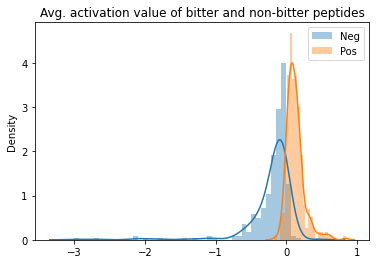

In [113]:
sns.distplot(neg_samples, label='Neg')
sns.distplot(pos_samples, label='Pos')
plt.legend()
plt.title('Avg. activation value of bitter and non-bitter peptides')
plt.show()

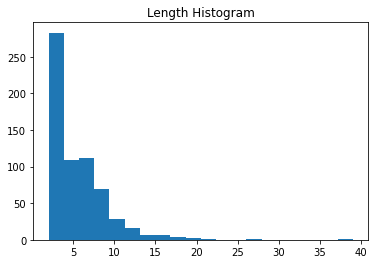

In [115]:
plt.hist([len(i) for i in descs], bins = 20)
plt.title('Length Histogram')
plt.show()

In [116]:
pos_descs = {}
neg_descs = {}
for i in range(len(labels)):
    k = descs[i]
    v = conv_feats[i]
    if labels[i] == 1:
        for _, d in enumerate(k):
            if d in pos_descs.keys():
                pos_descs[d].append(v[_])
            else:
                pos_descs[d] = [v[_]]
    else:
        for _, d in enumerate(k):
            if d in neg_descs.keys():
                neg_descs[d].append(v[_])
            else:
                neg_descs[d] = [v[_]]

In [117]:
desc_keys = sorted(list(set(list(pos_descs.keys()) + list(neg_descs.keys()))))

In [118]:
pos_desc_avg = []
neg_desc_avg = []
desc_avg = []
pos_desc_count = np.arange(len(desc_keys))
neg_desc_count = np.arange(len(desc_keys))
for i, k in enumerate(desc_keys):
    if k in pos_descs.keys():
        pos_desc_avg.append(np.mean(pos_descs[k]))
        pos_desc_count[i] = pos_desc_count[i] + len(pos_descs[k])
    else:
        pos_desc_avg.append(0)

    if k in neg_descs.keys():
        neg_desc_avg.append(np.mean(neg_descs[k]))
        neg_desc_count[i] = neg_desc_count[i] + len(neg_descs[k])
    else:
        neg_desc_avg.append(0)


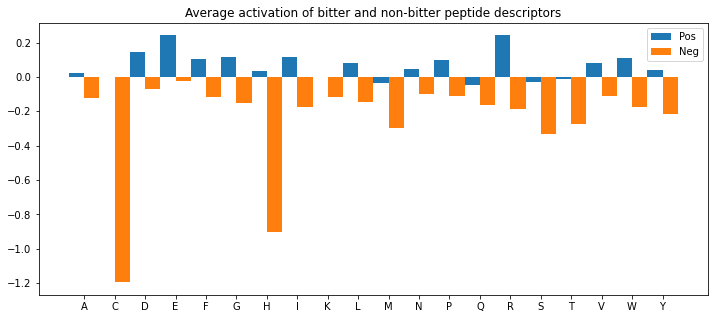

In [119]:
plt.figure(figsize=(12,5))
plt.bar(x=np.arange(20)-0.25, height = pos_desc_avg, width=-.5)
#plt.title('Bitter Descriptor Activations')
plt.bar(x=np.arange(20)+0.25, height = neg_desc_avg, width=-.5)
plt.xticks(np.arange(20), desc_keys)
plt.legend(['Pos', 'Neg'])
plt.title('Average activation of bitter and non-bitter peptide descriptors')
plt.show()

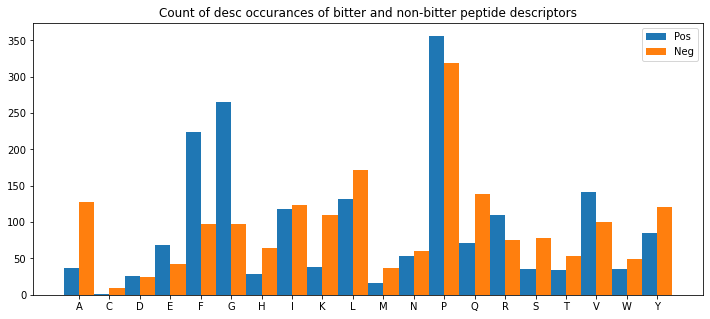

In [122]:
plt.figure(figsize=(12,5))
plt.bar(x=np.arange(20)-0.25, height = pos_desc_count, width=-.5)
#plt.title('Bitter Descriptor Activations')
plt.bar(x=np.arange(20)+0.25, height = neg_desc_count, width=-.5)
plt.xticks(np.arange(20), desc_keys)
plt.legend(['Pos', 'Neg'])
plt.title('Count of desc occurances of bitter and non-bitter peptide descriptors')
plt.show()

Seq: LAY, Label: 0, Cls prob: [2.2443227767944336, -2.068168878555298]


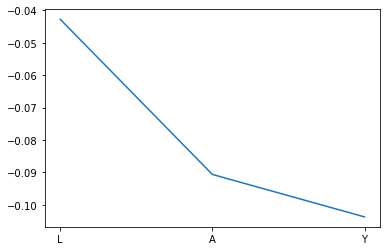

Seq: IR, Label: 0, Cls prob: [5.09041690826416, -5.773359298706055]


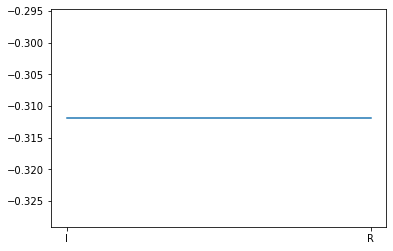

Seq: LNPPHQIYP, Label: 0, Cls prob: [4.220946311950684, -4.151304721832275]


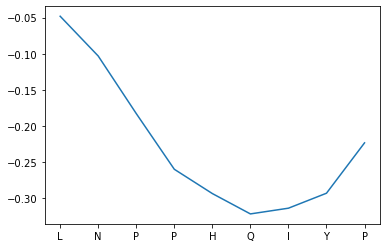

Seq: RPFFRPFFRPFF, Label: 1, Cls prob: [-2.675950050354004, 2.5751328468322754]


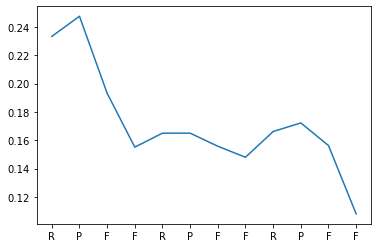

Seq: LVVYPWTQR, Label: 0, Cls prob: [1.6573752164840698, -1.7557588815689087]


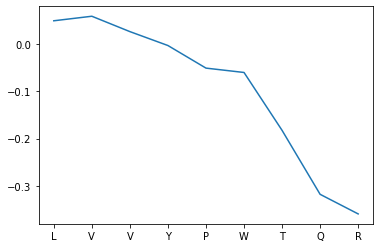

Seq: HIR, Label: 0, Cls prob: [9.477543830871582, -10.427103042602539]


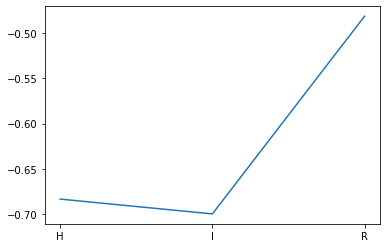

Seq: MF, Label: 0, Cls prob: [3.193742036819458, -3.0645434856414795]


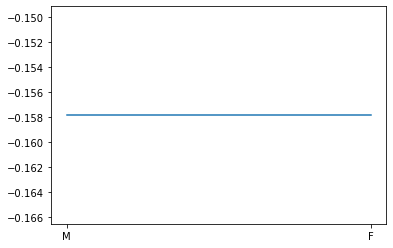

Seq: RGPGPIIV, Label: 1, Cls prob: [-3.298405647277832, 3.0319924354553223]


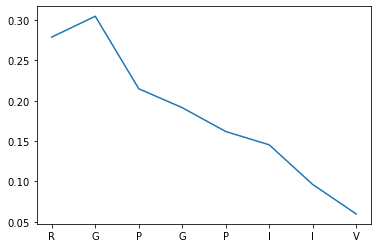

Seq: AHSY, Label: 0, Cls prob: [25.93924903869629, -26.355287551879883]


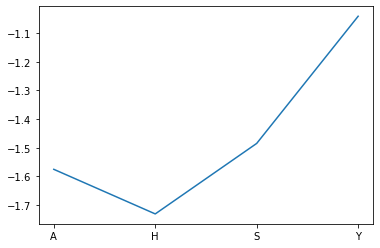

Seq: LHLPLP, Label: 0, Cls prob: [8.59707260131836, -8.601537704467773]


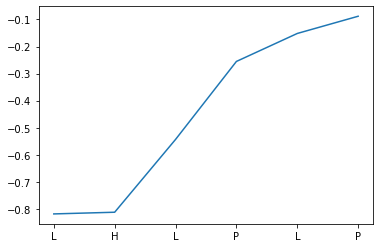

Seq: LAY, Label: 0, Cls prob: [2.2443227767944336, -2.068168878555298]


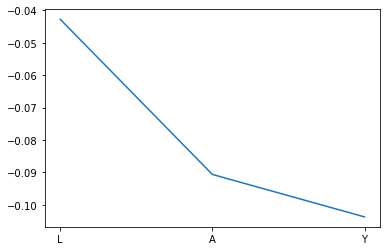

Seq: AVP, Label: 0, Cls prob: [0.36961352825164795, -0.31137198209762573]


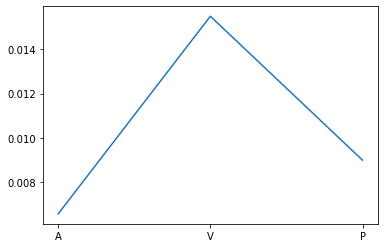

Seq: GFG, Label: 1, Cls prob: [-0.6202718019485474, 0.6987061500549316]


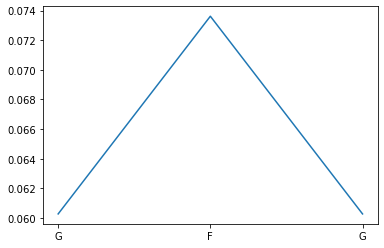

Seq: PHQIYP, Label: 0, Cls prob: [6.320889949798584, -6.299598217010498]


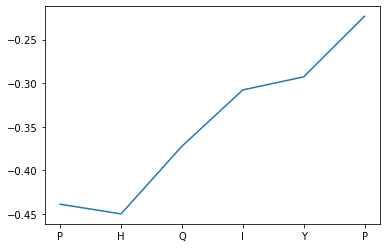

Seq: HSSIQSQPQAFT, Label: 0, Cls prob: [10.233552932739258, -10.317172050476074]


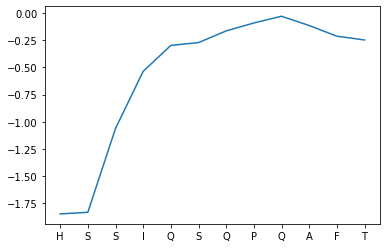

Seq: IYP, Label: 0, Cls prob: [6.114643573760986, -6.143742084503174]


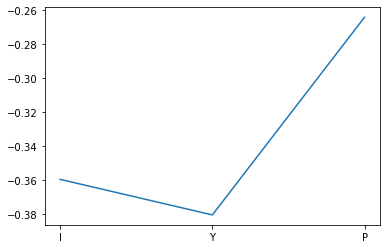

Seq: PVPQP, Label: 0, Cls prob: [1.107033610343933, -0.9852754473686218]


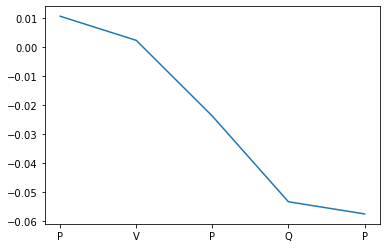

Seq: RGPPF, Label: 1, Cls prob: [-4.288916110992432, 4.058943271636963]


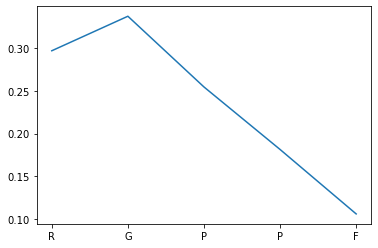

Seq: LD, Label: 1, Cls prob: [-2.7833378314971924, 2.766538143157959]


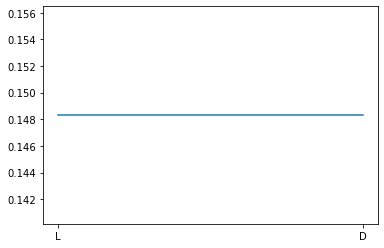

Seq: DL, Label: 1, Cls prob: [-2.7833378314971924, 2.766538143157959]


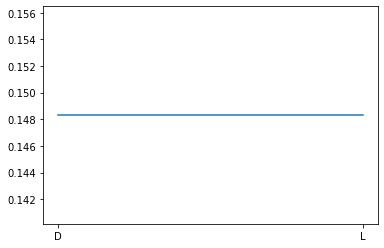

In [104]:
#i = np.random.randint(640)
#print(i)
for i in np.random.choice(640, 20):
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    #print(f'Activation: {conv_feats[i]}')
    #plt.bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    plt.plot(conv_feats[i])
    plt.xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    plt.show()

Seq: KIHPFAQTQSLVYP, Label: 0, Cls prob: [0.789438009262085, -0.7659547924995422]


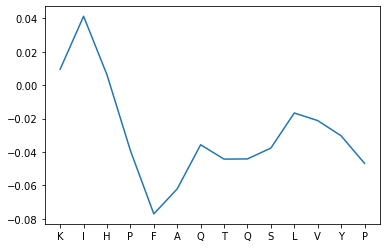

Seq: PVLGPVRGPFPIIV, Label: 1, Cls prob: [-1.154019832611084, 1.077823519706726]


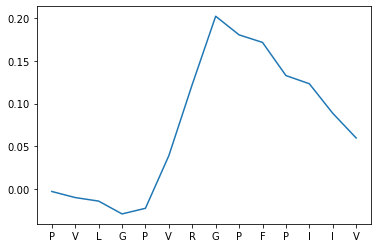

Seq: KFHSGIQSEPKAIP, Label: 0, Cls prob: [4.862032890319824, -4.805902004241943]


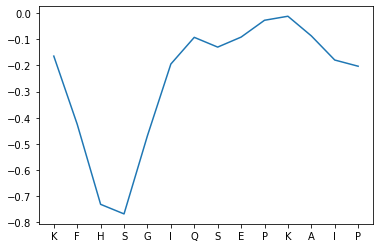

Seq: RGPPFIVRGPPFIV, Label: 1, Cls prob: [-3.2082571983337402, 3.0316479206085205]


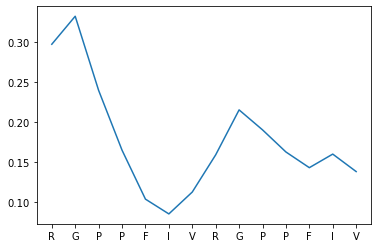

Seq: YQEPVLGPVRGPFPI, Label: 1, Cls prob: [-0.3491978049278259, 0.35856276750564575]


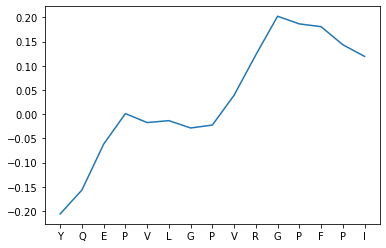

Seq: ENGLPVHLDQSIFRR, Label: 0, Cls prob: [1.7674334049224854, -1.7385140657424927]


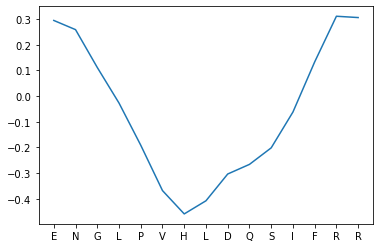

Seq: QPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.9784864783287048, 0.9221753478050232]


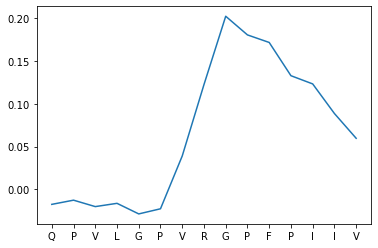

Seq: DKIYPSFQPQPLIYP, Label: 0, Cls prob: [3.7491705417633057, -3.6508328914642334]


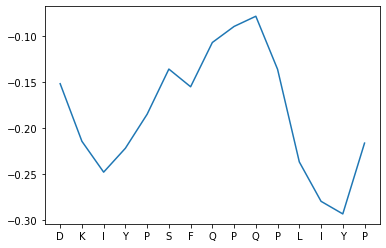

Seq: YQQPVLGPVRGPFPI, Label: 1, Cls prob: [0.48080331087112427, -0.5015508532524109]


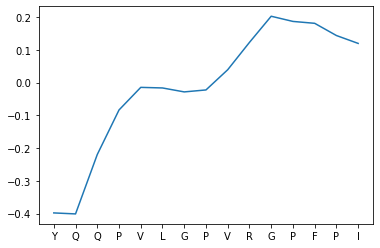

Seq: ENGLPVHLDQSIFRRP, Label: 0, Cls prob: [1.4805415868759155, -1.4602692127227783]


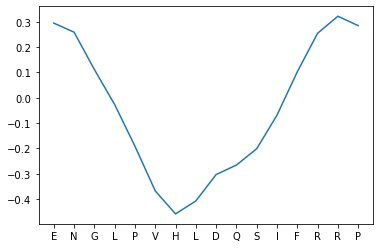

Seq: YQQPVLGPVRGPFPII, Label: 1, Cls prob: [0.1562306135892868, -0.2248173952102661]


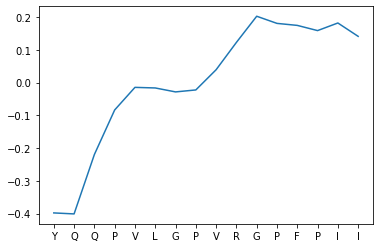

Seq: APKHKEMPFPKYPVEPF, Label: 1, Cls prob: [0.10051814466714859, -0.049906663596630096]


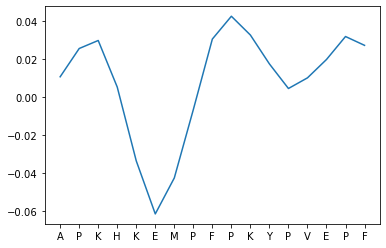

Seq: YQEPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.49912261962890625, 0.462375670671463]


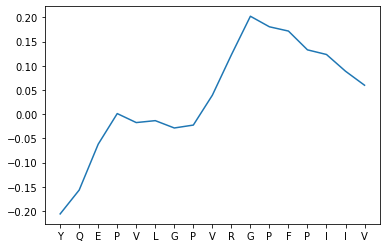

Seq: YQQPVLGPVRGPFPIIV, Label: 1, Cls prob: [0.2332313358783722, -0.29654809832572937]


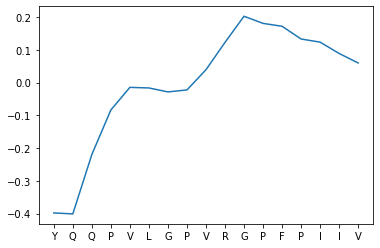

Seq: MAPKHKEMPFPKYPVEPF, Label: 1, Cls prob: [0.47276920080184937, -0.3976856768131256]


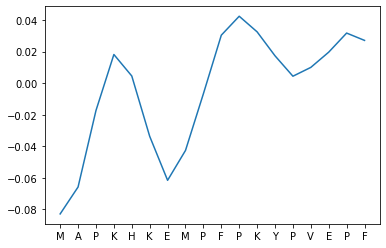

Seq: LVYPFPGPIPNSLPQNIPP, Label: 0, Cls prob: [0.11499863117933273, -0.12223152816295624]


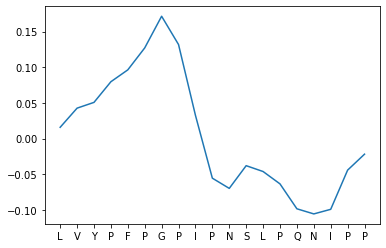

Seq: QDKIHPFAQTQSLVYPFPGP, Label: 1, Cls prob: [0.37957048416137695, -0.373851478099823]


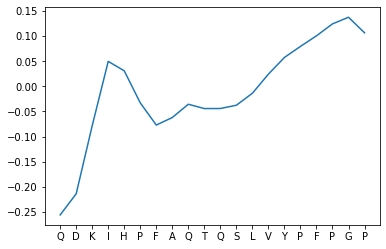

Seq: QNDKIHPFAQTQSLVYPFGPIP, Label: 1, Cls prob: [-0.12475715577602386, 0.09507723152637482]


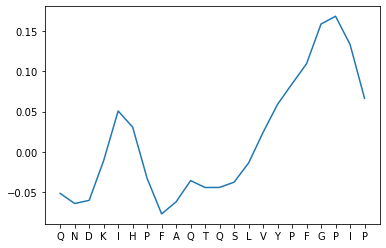

Seq: AQTQSLVYPFPGPIPNSLPQNIPPLTQ, Label: 1, Cls prob: [0.8070288896560669, -0.718755304813385]


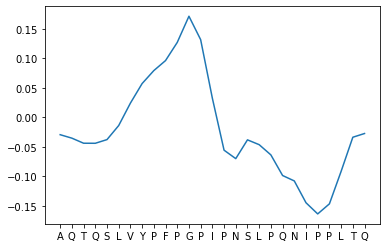

Seq: QNDKIHPFAQTQSLVYPFGPIPNSLPQNIPPLTQTPVVV, Label: 1, Cls prob: [0.42475593090057373, -0.39835962653160095]


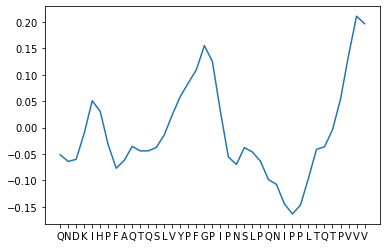

In [105]:
#i = np.random.randint(640)
#print(i)
for i in np.argsort([len(i) for i in descs])[-20:]:
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    #print(f'Activation: {conv_feats[i]}')
    #plt.bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    plt.plot(conv_feats[i])
    plt.xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    plt.show()